<a href="https://colab.research.google.com/github/insaiyancvk/speedyblackman/blob/main/speedy_work_acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Starting with Left/Right work

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# from IPython.display import Image
!pip install -q python-telegram-bot

Mounted at /content/drive
     |████████████████████████████████| 495 kB 8.5 MB/s 
     |████████████████████████████████| 58 kB 8.4 MB/s 
     |████████████████████████████████| 428 kB 87.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, telegram, json, cv2, time, random, zipfile, shutil
from math import floor
from PIL import Image

import torch
import torchvision

from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device} activated.")

cuda activated.


In [3]:
print("Initializing kaggle")
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/kaggle.json . && mv kaggle.json /root/.kaggle/kaggle.json

print("Downloading the dataset")
!kaggle datasets download insaiyancvk/nfs-rivals-acc-n-brake

print("Extracting the dataset")
with zipfile.ZipFile("nfs-rivals-acc-n-brake.zip") as zf:
  for member in tqdm(zf.infolist(), desc='Extracting'):
    try:
      zf.extract(member, "/content")
    except zipfile.error:
      pass
!rm nfs-rivals-acc-n-brake.zip

Initializing kaggle
 99% 1.34G/1.35G [00:10<00:00, 140MB/s]
100% 1.35G/1.35G [00:10<00:00, 134MB/s]
Extracting the dataset


Extracting:   0%|          | 0/6802 [00:00<?, ?it/s]

In [4]:
#@title Telegram bot
class send(): 

  def __init__(self):
    f = open ('/content/drive/MyDrive/tel.json', 'r')
    self.tel = json.load(f)
    f.close()
    self.bot = telegram.Bot(token=self.tel['token']) 

  def msg(self, mesg):
    self.bot.sendMessage(chat_id=self.tel['nnboiid'], text=mesg)

  def pic(self, path):
    self.bot.sendPhoto(chat_id=self.tel['nnboiid'], photo=open(path, 'rb'))
bot = send()

### Defining some constants

In [5]:
print("Initializing classes")

class_list = [
              'w',
              's']

print("Creating workspace")

drive = os.path.join("drive","MyDrive")
FOLDERS = {
    "TRAIN": os.path.join("train"),
    "TEST": os.path.join("test"),
    "WORKSPACE": os.path.join(drive,"speedata","workspace"),
    "MODELS": os.path.join(drive,"speedata","workspace","models"),
    "PERFORMANCE": os.path.join(drive,"speedata","workspace","performance")
}

for key in FOLDERS:
  if not os.path.isdir(FOLDERS[key]):
    print(key, "directory doesn't exist. Creating one.")
    os.mkdir(FOLDERS[key])
    print(key, "directory created.")

Initializing classes
Creating workspace


In [6]:
def cropper(path):
  im = Image.open(path)
  im = im.crop((0,300,1920,500))
  im.save(path)
  del im

### Cropping all images

In [8]:
testdir = {
    's':'/content/test/s',
    'w': '/content/test/w'
}
traindir = {
    's':'/content/train/s',
    'w': '/content/train/w'
}

In [9]:
for name in os.listdir(traindir['s']):
  cropper(traindir['s']+f'/{name}')
print('Cropping train/brake complete')

for name in os.listdir(traindir['w']):
  cropper(traindir['w']+f'/{name}')
print('Cropping train/accelerate complete')

Cropping train/brake complete
Cropping train/accelerate complete


In [10]:
for name in os.listdir(testdir['s']):
  cropper(testdir['s']+f'/{name}')
print('Cropping test/brake complete')

for name in os.listdir(testdir['w']):
  cropper(testdir['w']+f'/{name}')
print('Cropping test/accelerate complete')

Cropping test/brake complete
Cropping test/accelerate complete


### Defining the transformations on train and test data

In [25]:
print("Defining the transformations for the speedy data")
transformations = {
    "TRAIN": transforms.Compose([
                        transforms.Resize([256,256]),
                        transforms.ColorJitter(brightness=(0.8,1.5), contrast=(0.8,1.5), saturation=(0.8,1.5)),
                        # transforms.RandomAffine(degrees = 5, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]),
    "TEST": transforms.Compose([
                      transforms.Resize([256,256]),
                      transforms.ToTensor(),
                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
}

Defining the transformations for the speedy data


### Define dataset of the _speedata_

In [26]:
print("Creating a dataset of the speedata")
dataset = {
    "TRAIN": datasets.ImageFolder(
        FOLDERS["TRAIN"],
        transform = transformations["TRAIN"]
    ),
    "TEST": datasets.ImageFolder(
        FOLDERS["TEST"],
        transform = transformations["TEST"]
    )
}

Creating a dataset of the speedata


### Create Dataloader of the _speedata_

In [27]:
BATCH =  64#@param {type:"integer"}

In [28]:
print("Creating dataloaders")
dataloader = {
    "TRAIN": DataLoader(
        dataset["TRAIN"],
        batch_size = BATCH,
        shuffle = True
    ),
    "TEST": DataLoader(
        dataset["TEST"],
        batch_size = BATCH,
        shuffle = True
    )
}
print("Data preprocessing completed.")

Creating dataloaders
Data preprocessing completed.


# The G

In [15]:
#@title Epoch function

def epoch(model, test_loader ,train_loader, loss_func, optim, device):

  test_loss = 0
  test_accuracy = 0
  train_loss = 0
  train_accuracy = 0

  model = model.to(device)

  print("\t\tTraining the Neural Network")
  model.train(True)
  for image, label in tqdm(train_loader):
      optim.zero_grad()      
      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
        )
      loss.backward()
      optim.step()

      accuracy = np.average(
            np.argmax(
              output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      train_loss += loss.item()/len(train_loader) # training average loss
      train_accuracy += accuracy/len(train_loader) # training average accuracy
  model.train(False)

  print("\t\tValidating Neural Network")
  model.eval()

  for image, label in tqdm(test_loader):

      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
      )
      
      accuracy = np.average(
        np.argmax(
            output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      test_loss += loss.item()/len(test_loader) # Validation average loss
      test_accuracy += accuracy/len(test_loader) # Validation average accuracy
      
  return (

    # TRAIN LOSS
    train_loss,

    # TRAIN ACCURACY
    train_accuracy,

    # TEST LOSS, ACCURACY
    test_loss,
    test_accuracy
  )

In [16]:
EPOCH =  15#@param {type:"integer"}

[Reference](https://medium.com/analytics-vidhya/how-to-add-additional-layers-in-a-pre-trained-model-using-pytorch-5627002c75a5)

In [32]:
#@title Resnet18

model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features,2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
#@title install efficientnet
!pip install efficientnet_pytorch

In [ ]:
#@title import efficientnet
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)

Loaded pretrained weights for efficientnet-b0


In [29]:
#@title MobileNetV2
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features = 2)
)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [19]:
#@title AlexNet
model = torchvision.models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features = 2)

In [33]:
NAME = f"ResNet18acc_croppedimgs"
LR = 0.001

# model.load_state_dict(torch.load(f"/content/drive/MyDrive/speedata/workspace/models/{NAME}.pth"))

In [ ]:
done = False

model = model.to(device)

print(f"{NAME} INITIALIZED")
send().msg(f"{NAME} INITIALIZED")

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_loss_vals = []
train_accuracy_vals = []
test_loss_vals = []
test_accuracy_vals = []

start = time.time()
for ep in range(EPOCH):
  messages = ''

  print(f"Epoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}")
  messages += f"\nEpoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}" # for telegram

  vals = epoch(model, dataloader["TEST"], dataloader["TRAIN"], loss_func, optimizer, device)
  train_loss_vals.append(vals[0])
  train_accuracy_vals.append(vals[1])
  test_loss_vals.append(vals[2])
  test_accuracy_vals.append(vals[3])

  print(f"Test Loss: {test_loss_vals[-1]:.3f} Test Accuracy: {test_accuracy_vals[-1]:.3f}")
  print(f"Train Loss: {train_loss_vals[-1]:.3f} Train Accuracy: {train_accuracy_vals[-1]:.3f}")
  messages += f"\nTest Loss: {test_loss_vals[-1]:.3f} Test Accuracy: {test_accuracy_vals[-1]:.3f}" # for telegram
  messages += f"\nTrain Loss: {train_loss_vals[-1]:.3f} Train Accuracy: {train_accuracy_vals[-1]:.3f}"
  print(f"Time: {(time.time()-start)/60:.2f} min(s)")
  messages += f"\nTime elapsed: {(time.time()-start)/60:.2f} min(s)" # for telegram
  
  if len(test_loss_vals)>2:
    if all(x > test_loss_vals[-1] for x in test_loss_vals[:-1]):
      model_name = os.path.join(FOLDERS["MODELS"],f"{NAME}.pth")
      
      print(f"Improvement detected. Saving the model\n")
      messages += f"\nImprovement detected. Saving the model" # for telegram

      torch.save(model.state_dict(),model_name)

  fig, a = plt.subplots(1,2, squeeze=False, figsize=(14,5))
  a[0][0].plot(train_loss_vals, color='blue')
  a[0][0].set_title("Train Loss")
  a[0][0].grid(True)
  a[0][0].plot(test_loss_vals, color='green')
  a[0][0].grid(True)
  a[0][0].legend(['train','test'])
  a[0][0].set_xlabel('Epoch')
  a[0][0].set_ylabel('Loss')
  a[0][0].set_title('Model Loss')

  a[0][1].plot(train_accuracy_vals, color='blue')
  a[0][1].set_title("Model accuracy")
  a[0][1].grid(True)
  a[0][1].plot(test_accuracy_vals, color='green')
  a[0][1].grid(True)
  a[0][1].legend(['train','test'])
  a[0][1].set_xlabel('Epoch')
  a[0][1].set_ylabel('Accuracy')

  fig.suptitle(f"{NAME} {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")
  # plt.show()
  if ep>2:
    performanceplot = f"PERFORMANCE.jpg"
    fig.savefig(performanceplot)
    send().pic(performanceplot)
  send().msg(messages)
  send().msg('———————————————————————')

print(f"Total time taken to train for {EPOCH} epochs on {NAME}: {(time.time()-start)/60:.2f} min(s)")
send().msg(f"Total time taken to train for {EPOCH} epochs {NAME}: {(time.time()-start)/60:.2f} min(s)")
print(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")
send().msg(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")
done = True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

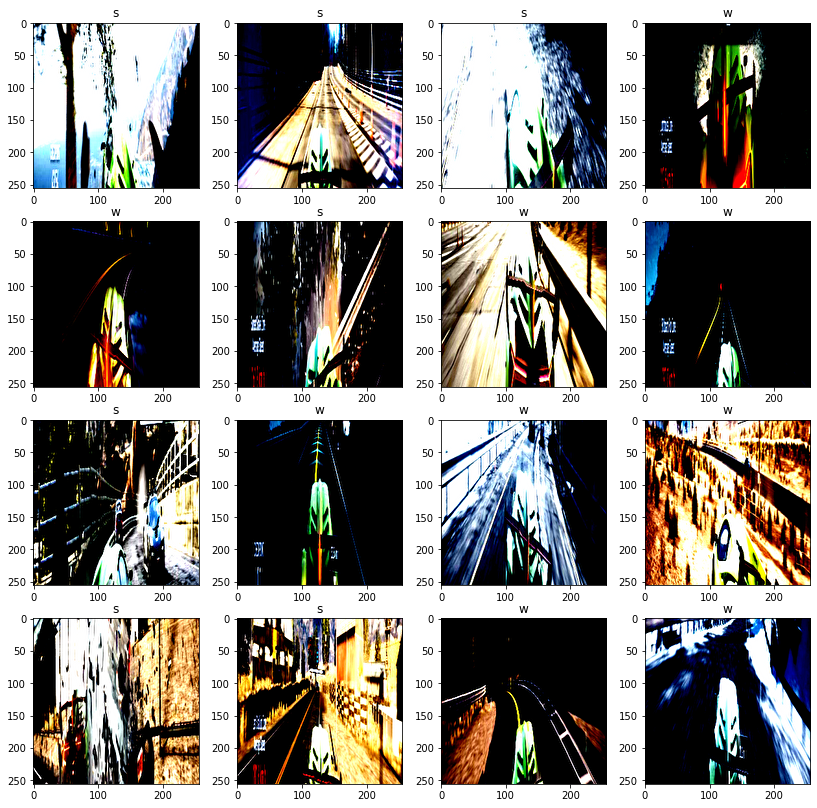

<Figure size 720x216 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [35]:
fig, axs = plt.subplots(4, 4, figsize=(14,14))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(4):
    for j in range(4):
        for image_list in (dataloader["TEST"]):

            p_image=image_list[0][0]
            x=p_image.squeeze()

            x = x.swapaxes(0,1)
            x = x.swapaxes(1,2)
            axs[j,i].imshow(x, interpolation='sinc', cmap='gray')

            with torch.no_grad():

              model.eval()
              p_image=p_image.cuda()
              lab=model(p_image.unsqueeze(0))
              lab=lab.cpu()
              max_index = np.argmax(lab[0]) 
              predicted = class_list[max_index]
            
            axs[j,i].title.set_text(predicted)
            break

plt.show()

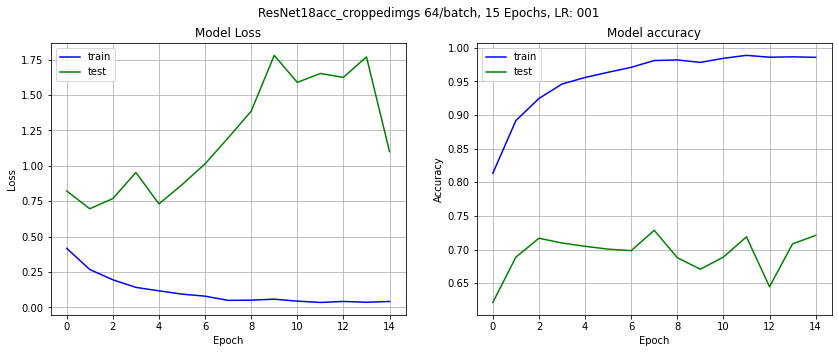

In [36]:
fig, a = plt.subplots(1,2, squeeze=False, figsize=(14,5))
a[0][0].plot(train_loss_vals, color='blue')
a[0][0].set_title("Train Loss")
a[0][0].grid(True)
a[0][0].plot(test_loss_vals, color='green')
a[0][0].grid(True)
a[0][0].legend(['train','test'])
a[0][0].set_xlabel('Epoch')
a[0][0].set_ylabel('Loss')
a[0][0].set_title('Model Loss')

a[0][1].plot(train_accuracy_vals, color='blue')
a[0][1].set_title("Model accuracy")
a[0][1].grid(True)
a[0][1].plot(test_accuracy_vals, color='green')
a[0][1].grid(True)
a[0][1].legend(['train','test'])
a[0][1].set_xlabel('Epoch')
a[0][1].set_ylabel('Accuracy')

fig.suptitle(f"{NAME} {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")

plt.show()
performanceplot = f"{FOLDERS['PERFORMANCE']}/{NAME}.jpg"
fig.savefig(performanceplot)
send().pic(performanceplot)

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? Y
